# RealnessGAN
Based on https://arxiv.org/abs/2002.05512, borrowed the anchor generating code and feature resampling snippet from their GitHub repo, which isn't used here. Loss is KL Divergence between the anchors and the discriminator output without the skewing done in their code. 


In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from models.msg import Generator, Discriminator#

In [2]:
batch_size_train = 64

def get_indices(dataset,class_name):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == class_name:
            indices.append(i)
    return indices

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
idx = get_indices(trainset, 0)

#Use the first one if you only want to produce a particular class
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=2, sampler = torch.utils.data.sampler.SubsetRandomSampler(idx))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=2, shuffle = True)

Files already downloaded and verified


torch.Size([64, 3, 32, 32])
tensor(1.) tensor(-1.)


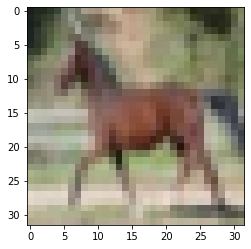

In [3]:
data_loader = iter(trainloader)
(data, target) = next(data_loader)

print(data.shape)
print(data.max(), data.min())
img = np.transpose(data[0], (1, 2, 0))
plt.imshow((img+1)/2)
plt.show()

In [0]:
class Basic_Gen(nn.Module):
  def __init__(self, image_size = (32, 32), noise_dim = 128):
    super(Basic_Gen, self).__init__()
    self.h, self.w = image_size[0]//8, image_size[1]//8
    self.Proj = nn.Linear(noise_dim, 256*self.h*self.w)
    self.C1 = nn.Conv2d(256, 128, 3, 1, 1)
    self.C2 = nn.Conv2d(128, 64, 3, 1, 1)
    self.C3 = nn.Conv2d(64, 32, 3, 1, 1)
    self.C4 = nn.Conv2d(32, 3, 3, 1, 1)

    self.C1.weight.data.normal_(0.0, 0.02)
    self.C2.weight.data.normal_(0.0, 0.02)
    self.C3.weight.data.normal_(0.0, 0.02)
    self.C4.weight.data.normal_(0.0, 0.02)
    self.C1 = nn.utils.spectral_norm(self.C1)
    self.C2 = nn.utils.spectral_norm(self.C2)
    self.C3 = nn.utils.spectral_norm(self.C3)
    self.C4 = nn.utils.spectral_norm(self.C4)

  def forward(self, z):
    x = F.leaky_relu(self.Proj(z))
    x = x.view(-1, 256, self.h, self.w)
    x = F.leaky_relu(self.C1(x))
    x = F.interpolate(x, scale_factor = 2)
    x = F.leaky_relu(self.C2(x))
    x = F.interpolate(x, scale_factor = 2)
    x = F.leaky_relu(self.C3(x))
    x = F.interpolate(x, scale_factor = 2)
    x = torch.tanh(self.C4(x))
    return x

class Basic_Disc(nn.Module):
  def __init__(self, image_size = (32, 32), anchor_size = 20):
    super(Basic_Disc, self).__init__()
    self.h, self.w = image_size[0]//8, image_size[1]//8
    self.anchor_size = anchor_size
    self.C1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.C2 = nn.Conv2d(64, 128, 4, 2, 1)
    self.C3 = nn.Conv2d(128, 256, 4, 2, 1)

    self.C1.weight.data.normal_(0.0, 0.02)
    self.C2.weight.data.normal_(0.0, 0.02)
    self.C3.weight.data.normal_(0.0, 0.02)
    self.C1 = nn.utils.spectral_norm(self.C1)
    self.C2 = nn.utils.spectral_norm(self.C2)
    self.C3 = nn.utils.spectral_norm(self.C3)

    self.D_mu = nn.Linear(256*self.h*self.w, anchor_size)
    self.D_logvar = nn.utils.spectral_norm(nn.Linear(256*self.h*self.w, anchor_size))

    self.D_mu.weight.data.normal_(0.0, 0.02)
    self.D_mu = nn.utils.spectral_norm(self.D_mu)

  def forward(self, x, device):
    x = F.leaky_relu(self.C1(x))
    x = F.leaky_relu(self.C2(x))
    x = F.leaky_relu(self.C3(x))
    x = x.view(-1, 256*self.h*self.w)
    mu, logvar = self.D_mu(x), self.D_logvar(x)                         #Uncomment for feature resampling
    #std = logvar.mul(0.5).exp_()
    #epsilon = torch.randn(input.shape[0], self.anchor_size).to(device)
    #x = epsilon.mul(std).add_(mu)
    x = mu
    x = F.softmax(x, dim = 1)
    return x

def compute_kl_div(p, q):
  return (p * (p / q).log()).sum()

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

noise_dim = 128
anchor_size = 20
netG = Basic_Gen(image_size = (32,32), noise_dim = noise_dim).to(device)
netD = Basic_Disc(image_size = (32, 32), anchor_size = anchor_size).to(device)

if torch.cuda.device_count() > 1:
    netG = nn.DataParallel(netG, list(range(torch.cuda.device_count())))
    netD = nn.DataParallel(netD, list(range(torch.cuda.device_count())))

#Making the random anchor distributions
gauss = np.random.normal(0, 0.1, 1000)
count, bins = np.histogram(gauss, anchor_size)
A0 = torch.Tensor(count / sum(count)).to(device)

unif = np.random.uniform(-1, 1, 1000)
count, bins = np.histogram(unif, anchor_size)
A1 = torch.Tensor(count / sum(count)).to(device)

#Two Timescale Update Rule
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [36]:
epochs = 500
disc_steps = 2 
path = "./saved_models/"



for epoch in range(epochs):
    for i, (data, target) in enumerate(trainloader):

        #Dealing with the discriminator################################
        #Specify number of disc updates above##############
        for k in range(disc_steps):
            netD.zero_grad()
        
            b_size = data.size(0)//2
            real_images = data[k*b_size:(k+1)*b_size].to(device)
            b_size = real_images.size(0)

            output = netD(real_images, device).view(b_size, -1)
            errD_real = compute_kl_div(A1, output)
            errD_real.backward()
            D_x = output

            noise = torch.randn(b_size, noise_dim, device = device)
            fake = netG(noise)
            #print(D_x)

            output = netD(fake.detach(), device).view(b_size, -1)
            errD_fake = compute_kl_div(A0, output)
            errD_fake.backward()
            D_G_z1 = output

            errD = errD_fake + errD_real
            optimizerD.step()
            
        #Dealing with the generator###################################
        netG.zero_grad()

        real_output = netD(real_images, device).view(b_size, -1)
        fake_output = netD(fake, device).view(b_size, -1)
        errG = compute_kl_div(real_output, fake_output) - compute_kl_div(A0, fake_output)

        D_G_z2 = fake_output
        errG.backward()
        optimizerG.step()

        if i%100 == 0:
            print(epoch, epochs, i, len(trainloader), errD.item(), errG.item())#, D_x, D_G_z1, D_G_z2)
            
    if epoch%2 == 0:
        !nvidia-smi;
    if epoch%100 == 0:
        torch.save(netG.state_dict(), "Re_G.pth")
        torch.save(netD.state_dict(), "Re_D.pth")

0 500 0 782 7.949227333068848 -4.427469730377197
0 500 100 782 8.179499626159668 -4.817734718322754
0 500 200 782 7.815239906311035 -3.943979024887085
0 500 300 782 7.8231201171875 -4.144700050354004
0 500 400 782 8.148619651794434 -4.598517417907715
0 500 500 782 8.423835754394531 -4.443541049957275
0 500 600 782 7.761417865753174 -4.088024139404297
0 500 700 782 8.22991943359375 -4.344038963317871
Sun May 10 17:07:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A

KeyboardInterrupt: ignored

torch.Size([40, 3, 32, 32])


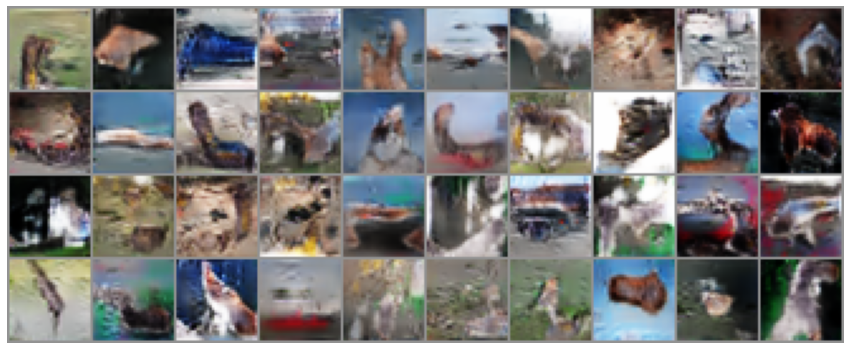

In [37]:
noise = torch.randn(40, noise_dim, device = device)

with torch.no_grad():
  fake = []
  for i in range(7):
    f = netG(noise[i*10:(i+1)*10])
    fake.append(f.cpu())
  fake = torch.cat(fake)

print(fake.shape)
grid = torchvision.utils.make_grid(fake, nrow = 10, padding = 1, pad_value = 0.15)
f = plt.figure(figsize=(15,15))
plt.imshow((grid.permute(1, 2, 0)+1)/2)
plt.axis('off')
plt.show()
